In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math

import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from pymongo import MongoClient
import json

from wordcloud import WordCloud

In [2]:
con = MongoClient('localhost',27017)
db = con.politica

In [3]:
dataset = pd.DataFrame()

In [4]:
list_tweets = list(db.tweets_alckmin.find().limit(8000))
text_tweets = []
for tweet in list_tweets[0:math.floor(len(list_tweets)*0.5)]:
    twitterText = ""
    if('retweeted_status' in tweet):
        if('extended_tweet' in tweet['retweeted_status']):
            twitterText = tweet['retweeted_status']['extended_tweet']['full_text']
        else:
            twitterText = tweet['retweeted_status']['text']

    elif('extended_tweet' in tweet):
        twitterText = tweet['extended_tweet']['full_text']
    else:
        twitterText = tweet['text']
    
    text_tweets.append(twitterText)

dataset['text'] = pd.Series(text_tweets)

In [5]:
dataset['text_processed'] = np.nan

In [6]:
stemmer = nltk.stem.RSLPStemmer()
for ind, tweet in enumerate(dataset['text']):
    t = tweet
    t = t.lower() # removendo letras maiúsculas
    t = re.sub(r'(\b)?@\w+','',t) #removendo referências a outros perfis
    t = re.sub(r'(\b)?#\w+','',t) #removendo hashtags
    t = re.sub(r'http\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'https\S+','',t,flags=re.MULTILINE) #removendo links
    t = re.sub(r'(\w+)?\d(\w+)?','',t) # removendo números
    t = re.sub(r',|\"|!|\n|:|\.|\?|;|\(|\)|#',' ',t) #removendo pontuações
    
    # removendo stopwords
    nsw = ''
    for word in t.split(' '):
        if word not in stopwords.words('portuguese'):
            nsw += word+' '
    t = nsw.strip()
    t = re.sub(r' +',' ',t) # removendo espaços duplos
    t = t.strip() # remover espaços vazios no início e no fim
    
    # isolando o radical das palavras
    if len(t) > 0:
        t = t.split(' ')
        ste = [stemmer.stem(word) for word in t]
        processedTweet = ' '.join(ste)
        dataset['text_processed'][ind] = processedTweet
    else:
        dataset['text_processed'][ind] = ''

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alysson/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
dataset.head()

,text,text_processed
0,Falou o Ladrão de Merenda que está curtindo a ...,fal ladr merend curt liberdad
1,Num é? Já que o @geraldoalckmin virou comentar...,é vir comentar pris fale-n sobr paul pret
2,"@ADRIENNEVILLELA Sim, mas o caso do Alckmin é ...",sim cas alckmin é import porqu é import
3,Alckmin dá um drible na Lava-Jato e é convoca...,alckmin dá dribl lava-jat é convoc tit
4,Coisas que eu queria ter:\n\n- fígado do Zeca ...,cois quer ter - fíg zec pagod - namor fát bern...


In [8]:
count_vect = CountVectorizer()
matrix_vectorized = count_vect.fit_transform(dataset['text_processed'].values.tolist())
print(matrix_vectorized.shape)
print(count_vect.get_feature_names()[0:10])

(4000, 3820)
['aaaaaaaaaaaahhhhhhh', 'aaahahah', 'abaf', 'abaix', 'abandon', 'abc', 'abelh', 'abenço', 'abert', 'abr']


# Clustering with DBScan

In [9]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN

In [10]:
matrix_distances_euclidean = euclidean_distances(matrix_vectorized)
matrix_distances_euclidean.shape

(4000, 4000)

In [11]:
print("Distância euclidiana, máximo: ",matrix_distances_euclidean.max())
print("Distância euclidiana, média: ",matrix_distances_euclidean.mean())
print("Distância euclidiana, std: ",matrix_distances_euclidean.std())
print("Distância euclidiana, mínimo: ",matrix_distances_euclidean.std())

Distância euclidiana, máximo:  17.635192088548397
Distância euclidiana, média:  5.172836588190742
Distância euclidiana, std:  1.4959540874890467
Distância euclidiana, mínimo:  1.4959540874890467


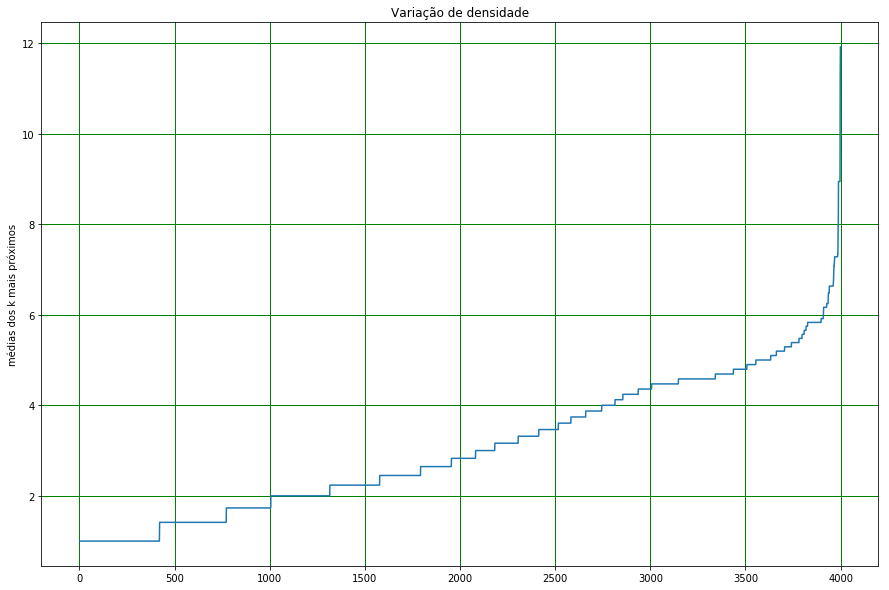

In [17]:
def k_dist(k, i, points):
    dist = []
    smaller = np.max(points)
    for i in range(0,k):
        for j in range(len(points)):
            if j != i:
                if points[j] < smaller and points[j] != 0:
                    smaller = points[j]
        dist.append(smaller)
    return np.mean(dist)

i = 0
y = []
while i < len(matrix_distances_euclidean):
    y.append(k_dist(3,i,matrix_distances_euclidean[i]))
    i += 1
y.sort()
    
plt.figure(figsize=(15,10))
plt.plot(y)
plt.grid(color='g', linestyle='-', linewidth=1)
plt.ylabel('médias dos k mais próximos')
plt.title('Variação de densidade')
plt.show()

In [168]:
minPoints = math.log(len(matrix_distances_euclidean))
dbscan_euclidean_distance = DBSCAN(eps=matrix_distances_euclidean.mean(), min_samples= minPoints, metric="precomputed")
clusters_euclidean_dbscan = dbscan_euclidean_distance.fit(matrix_distances_euclidean)
dataset['cluster_euclidean_dbscan'] = clusters_euclidean_dbscan.labels_

### Grid Search for *eps* and *minPoints*

# Clustering with Kmeans

In [204]:
# from sklearn.metrics.pairwise import euclidean_distances
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [209]:
# kmeans_euclidean_distance = MiniBatchKMeans(n_clusters=3, precompute_distances=True)
kmeans_euclidean_distance = MiniBatchKMeans(n_clusters=3)
# clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_distances_euclidean)
clusters_euclidean_kmeans = kmeans_euclidean_distance.fit(matrix_vectorized)
dataset['cluster_euclidean_kmeans'] = clusters_euclidean_kmeans.labels_

In [220]:
dataset.text[dataset.cluster_euclidean_kmeans == 0]

847    OLHA ISSO! Quer ver tucano preso? vá ao zoológ...
Name: text, dtype: object

# Clusters

* **Avaliar a clusterização por meio de métricas conhecidas**
1. [Experiments on the Automatic Induction of German Semantic Verb Classes](http://www.schulteimwalde.de/research/phd.html)
* **Obs da Tese acima:** Chapter 4: Clustering Algorithms and Evaluations

In [169]:
dataset['cluster_euclidean_dbscan'].value_counts()

 0     3657
-1      174
 2       40
 1       22
 6       21
 9       16
 7       14
 10      14
 5       11
 3       11
 4       11
 8        9
Name: cluster_euclidean_dbscan, dtype: int64

In [211]:
dataset['cluster_euclidean_kmeans'].value_counts()

1    3920
2      79
0       1
Name: cluster_euclidean_kmeans, dtype: int64

* ### Evaluation

In [212]:
#Sum-of-Squared-Error
kmeans_euclidean_distance.inertia_

56380.14443514797

In [213]:
#Silhouette Value

from sklearn.metrics import silhouette_score

silhouette_score(X=matrix_distances_euclidean,labels=kmeans_euclidean_distance.labels_)

-0.19346856316685848

In [170]:
silhouette_score(X=matrix_distances_euclidean,labels=dbscan_euclidean_distance.labels_)

0.27752570867053633

* ### Polarity of the tweets

In [19]:
from Polarity import Polarity

In [20]:
Polarity.load()
Polarity.base_lexica.head()

,palavra,gn,tg,pol,anot,pos
0,"abafadas,abafado",GN=fp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
1,"abafado,abafado",GN=ms,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
2,"abafados,abafado",GN=mp,TG=HUM,POL=-1,ANOT=JALC,PoS=Adj
3,"abafante,abafante",GN=fs,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj
4,"abafante,abafante",GN=ms,TG=HUM,POL=-1,ANOT=MAN,PoS=Adj


In [21]:
dataset['polaridade'] = 0

j = 0
for tweet in dataset.text:
    twt = Polarity.preProcessor(tweet)
    score = 0
    for p in twt.split(' '):
        score += Polarity.searchWord(p)
    dataset.polaridade[j] = score
    j += 1

/home/alysson/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [171]:
dataset.head()

,text,text_processed,cluster_euclidean_dbscan,cluster_euclidean_kmeans,polaridade
0,Falou o Ladrão de Merenda que está curtindo a ...,fal ladr merend curt liberdad,0,1,-1
1,Num é? Já que o @geraldoalckmin virou comentar...,é vir comentar pris fale-n sobr paul pret,0,1,-1
2,"@ADRIENNEVILLELA Sim, mas o caso do Alckmin é ...",sim cas alckmin é import porqu é import,0,1,4
3,Alckmin dá um drible na Lava-Jato e é convoca...,alckmin dá dribl lava-jat é convoc tit,0,1,2
4,Coisas que eu queria ter:\n\n- fígado do Zeca ...,cois quer ter - fíg zec pagod - namor fát bern...,0,2,-7


* ### Analyzes
    * **Sugestão de Análise:** Verificar as palavras mais frequentes em cada cluster, e dentro de cada cluster, verificar a frequência das palavras de cada grupo de tweet (positivos, negativos e neutros)
        * Nuvem de palavras de cada cluster
        * Nuvem de palvras de cada polaridade de cada cluster

In [27]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].sum()

cluster_euclidean_dbscan
-1     -85
 0   -4581
 1     -45
 2     -64
Name: polaridade, dtype: int64

In [172]:
dataset.groupby('cluster_euclidean_dbscan')['polaridade'].mean()

cluster_euclidean_dbscan
-1    -2.298851
 0    -1.047853
 1    -1.000000
 2    -6.000000
 3    -3.000000
 4     5.000000
 5    -3.000000
 6    -3.000000
 7    -6.000000
 8    -5.000000
 9    -4.000000
 10   -1.000000
Name: polaridade, dtype: float64

In [197]:
dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
clusters_dbscan = []
for i in range(-1,len(dataset.groupby('cluster_euclidean_dbscan'))-1):
    dbscan_pos,dbscan_neg,dbscan_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_dbscan[dataset.cluster_euclidean_dbscan == i].index].values:
        if v < 0:
            dbscan_neg += 1
        if v > 0:
            dbscan_pos += 1
        if v == 0:
            dbscan_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(dbscan_pos), '; neg = ',str(dbscan_neg), '; neu=',str(dbscan_neu))
    clusters_dbscan.append((dbscan_pos,dbscan_neg,dbscan_neu))

Cluster -1
pos =  34 ; neg =  123 ; neu= 17
Cluster 0
pos =  783 ; neg =  2142 ; neu= 732
Cluster 1
pos =  0 ; neg =  22 ; neu= 0
Cluster 2
pos =  0 ; neg =  40 ; neu= 0
Cluster 3
pos =  0 ; neg =  11 ; neu= 0
Cluster 4
pos =  11 ; neg =  0 ; neu= 0
Cluster 5
pos =  0 ; neg =  11 ; neu= 0
Cluster 6
pos =  0 ; neg =  21 ; neu= 0
Cluster 7
pos =  0 ; neg =  14 ; neu= 0
Cluster 8
pos =  0 ; neg =  9 ; neu= 0
Cluster 9
pos =  0 ; neg =  16 ; neu= 0
Cluster 10
pos =  0 ; neg =  14 ; neu= 0


[11.09053651 46.28174586  4.69041576  6.32455532  3.31662479  0.
  3.31662479  4.58257569  3.74165739  3.          4.          3.74165739]


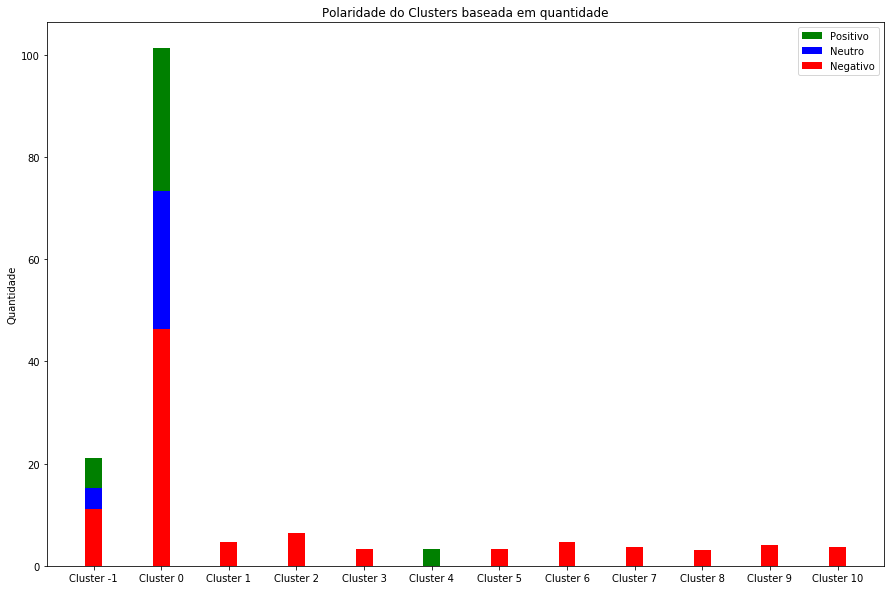

In [199]:
def normalize(t, i):
    return math.sqrt(t[i])

def labelCluster(i):
    return 'Cluster '+str(i)

# Gráfico de distribuição de polaridades

C = 12
dbscan_pos = np.array([normalize(i,0) for i in clusters_dbscan])
dbscan_neg = np.array([normalize(i,1) for i in clusters_dbscan])
dbscan_neu = np.array([normalize(i,2) for i in clusters_dbscan])

print(dbscan_neg)

ind = np.arange(C)
width = 0.25

plt.figure(figsize=(15,10))
pNeg = plt.bar(ind, dbscan_neg, width, color='r')
pNeu = plt.bar(ind, dbscan_neu, width, bottom=dbscan_neg, color='b')
pPos = plt.bar(ind, dbscan_pos, width, bottom=dbscan_neu+dbscan_neg, color='g')


plt.ylabel('Quantidade')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, tuple([labelCluster(i) for i in range(-1,C+1)]))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positivo', 'Neutro', 'Negativo'))

plt.show()

In [200]:
# Nuvem de palavras dos clustersfor i in count_clusters_dbscan:
count_clusters_dbscan = dataset.cluster_euclidean_dbscan.value_counts().index.tolist()
count_clusters_dbscan.sort()

In [201]:
for i in count_clusters_dbscan:
    text = Polarity.preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_dbscan == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(7,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

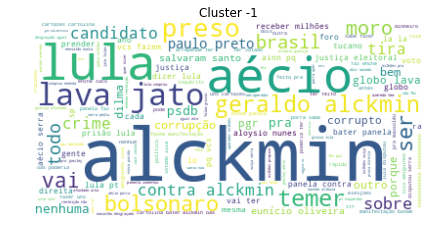

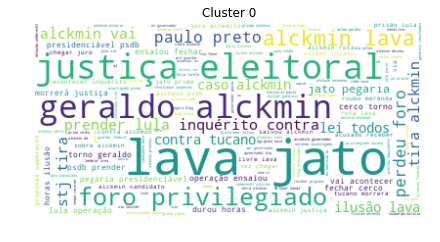

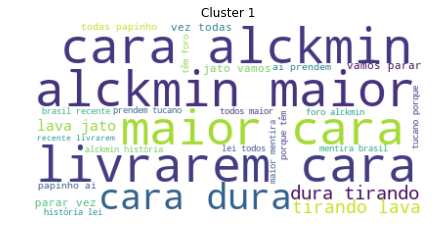

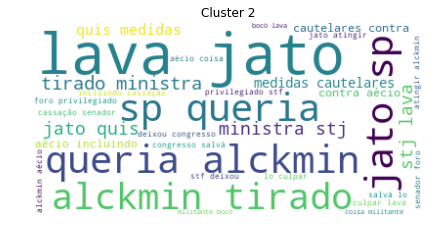

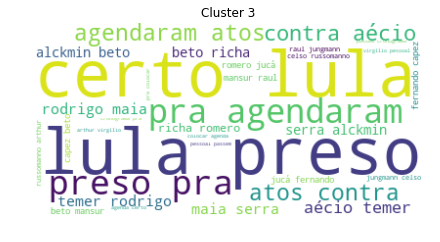

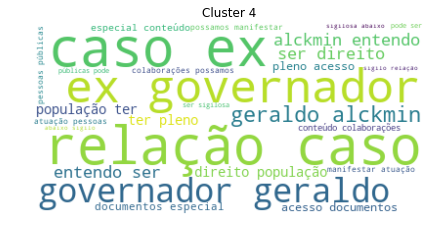

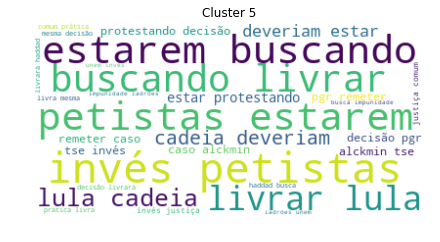

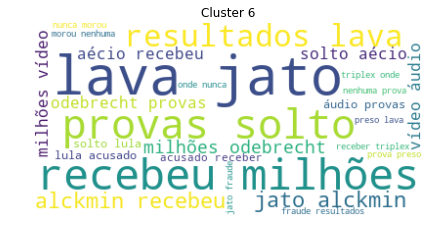

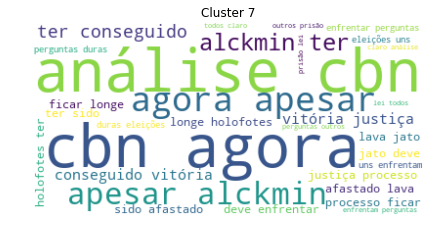

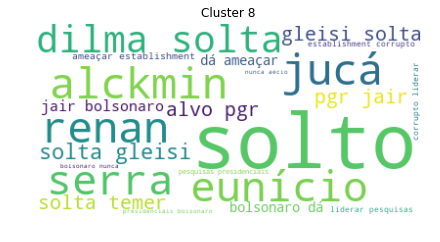

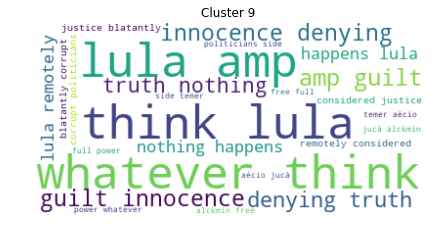

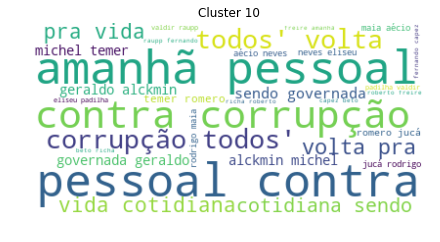

In [202]:
plt.show()

In [214]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].sum()

cluster_euclidean_kmeans
0      -1
1   -4534
2    -240
Name: polaridade, dtype: int64

In [215]:
dataset.groupby('cluster_euclidean_kmeans')['polaridade'].mean()

cluster_euclidean_kmeans
0   -1.000000
1   -1.156633
2   -3.037975
Name: polaridade, dtype: float64

In [216]:
kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
clusters_kmeans = []
for i in range(0,3):
    kmeans_pos,kmeans_neg,kmeans_neu = 0,0,0
    for v in dataset.polaridade[dataset.cluster_euclidean_kmeans[dataset.cluster_euclidean_kmeans == i].index].values:
        if v < 0:
            kmeans_neg += 1
        if v > 0:
            kmeans_pos += 1
        if v == 0:
            kmeans_neu += 1
    print('Cluster '+str(i))
    print('pos = ',str(kmeans_pos), '; neg = ',str(kmeans_neg), '; neu=',str(kmeans_neu))
    clusters_kmeans.append((kmeans_pos,kmeans_neg,kmeans_neu))

Cluster 0
pos =  0 ; neg =  1 ; neu= 0
Cluster 1
pos =  828 ; neg =  2343 ; neu= 749
Cluster 2
pos =  0 ; neg =  79 ; neu= 0


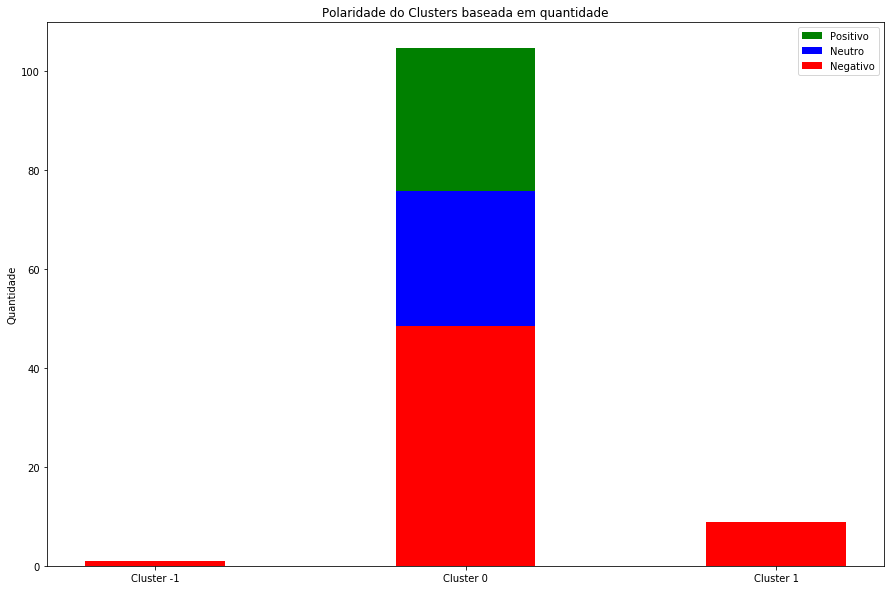

In [217]:
# Gráfico de distribuição de polaridades

C = 3
kmeans_pos = np.array([normalize(i,0) for i in clusters_kmeans])
kmeans_neg = np.array([normalize(i,1) for i in clusters_kmeans])
kmeans_neu = np.array([normalize(i,2) for i in clusters_kmeans])

ind = np.arange(C)
width = 0.45

plt.figure(figsize=(15,10))
pNeg = plt.bar(ind, kmeans_neg, width, color='r')
pNeu = plt.bar(ind, kmeans_neu, width, bottom=kmeans_neg, color='b')
pPos = plt.bar(ind, kmeans_pos, width, bottom=kmeans_neu+kmeans_neg, color='g')


plt.ylabel('Quantidade')
plt.title('Polaridade do Clusters baseada em quantidade')
plt.xticks(ind, ('Cluster -1', 'Cluster 0', 'Cluster 1', 'Cluster 2'))
plt.legend((pPos[0], pNeu[0], pNeg[0]), ('Positivo', 'Neutro', 'Negativo'))

plt.show()

In [218]:
# Nuvem de palavras dos clusters
count_clusters_kmeans = dataset.cluster_euclidean_kmeans.value_counts().index.tolist()
count_clusters_kmeans.sort()

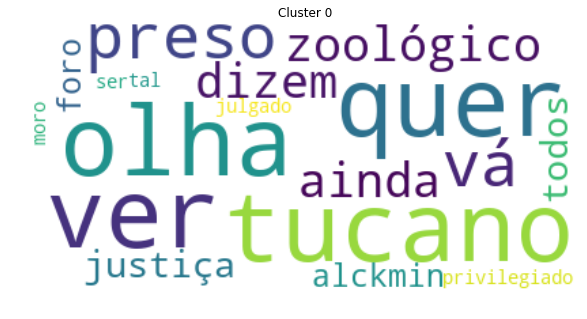

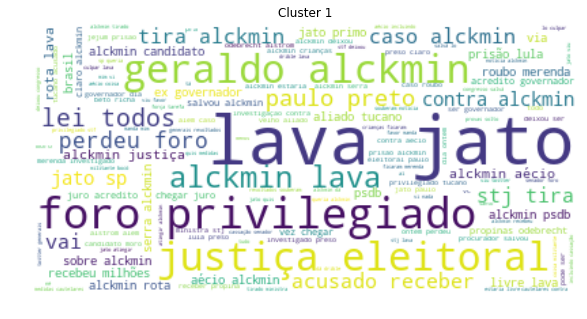

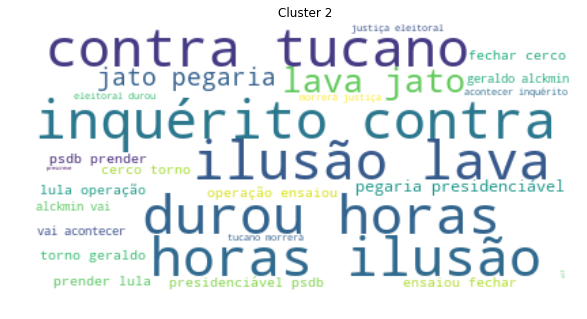

In [219]:
for i in count_clusters_kmeans:
    text = Polarity.preProcessor(" ".join(dataset.text[dataset.cluster_euclidean_kmeans == i].tolist()))
    
    wordcloud = WordCloud(background_color='white', max_words=2500).generate(text)

    plt.figure(figsize=(10,5))
    plt.title('Cluster '+str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

plt.show()